In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, sequence, dimension)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average= 'macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
class LSTM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.lstm = nn.LSTM(config.input_size, config.hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(config.hidden_size//2, config.output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        lstm_out, hidden = self.lstm(x, hidden)
        last_output = lstm_out[:, -1, :]
        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))

# trainer 구현

In [11]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")
    
  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [12]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 6000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  input_size = 19        # 처음 input의 차원의 개수 (feature수와 같다)
  hidden_size=512        # LSTM hidden vector size
  output_size = 2        # output 차원의 개수

config = Config()

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [14]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [15]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


In [16]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 6000
failure(1)의 개수 : 1569


In [17]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [18]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [19]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [20]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 4541
Total number of data samples in valid_loader: 1513
Total number of data samples in test_loader: 1514


In [21]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=1)

In [22]:
# model, optimizer, loss_function 구현하고 결합시키기
model = LSTM(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [24]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/6000_LSTM') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 6/6 [00:00<00:00, 388.08it/s]


Model saved
TRAIN LOSS = 0.0020945663560830766, TRAIN ACC = 0.7905747632680027, 
VALID LOSS = 0.0016938252946988527, VALID ACC = 0.7964309319233311, 
epoch 2


100%|██████████| 6/6 [00:00<00:00, 425.67it/s]


TRAIN LOSS = 0.0017213664884951586, TRAIN ACC = 0.7925567055714601, 
VALID LOSS = 0.0016768593427288713, VALID ACC = 0.7964309319233311, 
epoch 3


100%|██████████| 6/6 [00:00<00:00, 410.68it/s]


TRAIN LOSS = 0.0017923340939708912, TRAIN ACC = 0.7927769213829553, 
VALID LOSS = 0.001758022038099865, VALID ACC = 0.7964309319233311, 
epoch 4


100%|██████████| 6/6 [00:00<00:00, 351.99it/s]


Model saved
TRAIN LOSS = 0.0017275220101899812, TRAIN ACC = 0.7927769213829553, 
VALID LOSS = 0.0015871113723898596, VALID ACC = 0.7970918704560476, 
epoch 5


100%|██████████| 6/6 [00:00<00:00, 351.74it/s]


TRAIN LOSS = 0.0016528901563449936, TRAIN ACC = 0.7923364897599647, 
VALID LOSS = 0.001565891291554685, VALID ACC = 0.7964309319233311, 
epoch 6


100%|██████████| 6/6 [00:00<00:00, 345.45it/s]


TRAIN LOSS = 0.0016132941056494932, TRAIN ACC = 0.7927769213829553, 
VALID LOSS = 0.001505156561623956, VALID ACC = 0.7964309319233311, 
epoch 7


100%|██████████| 6/6 [00:00<00:00, 395.48it/s]


TRAIN LOSS = 0.0015949759418233012, TRAIN ACC = 0.7927769213829553, 
VALID LOSS = 0.00169895119566202, VALID ACC = 0.7964309319233311, 
epoch 8


100%|██████████| 6/6 [00:00<00:00, 415.37it/s]


TRAIN LOSS = 0.0017376092792318614, TRAIN ACC = 0.7927769213829553, 
VALID LOSS = 0.001758614755669573, VALID ACC = 0.7964309319233311, 
epoch 9


100%|██████████| 6/6 [00:00<00:00, 470.86it/s]


TRAIN LOSS = 0.001738638453640042, TRAIN ACC = 0.7925567055714601, 
VALID LOSS = 0.0017170164455897904, VALID ACC = 0.7964309319233311, 
epoch 10


100%|██████████| 6/6 [00:00<00:00, 381.64it/s]


TRAIN LOSS = 0.0017612624853567205, TRAIN ACC = 0.7927769213829553, 
VALID LOSS = 0.0018461590678346765, VALID ACC = 0.7964309319233311, 
epoch 11


100%|██████████| 6/6 [00:00<00:00, 426.73it/s]


TRAIN LOSS = 0.0019040089875846885, TRAIN ACC = 0.7929971371944505, 
VALID LOSS = 0.001933047610722231, VALID ACC = 0.7964309319233311, 
epoch 12


100%|██████████| 6/6 [00:00<00:00, 373.61it/s]


TRAIN LOSS = 0.0018774329487171186, TRAIN ACC = 0.7932173530059459, 
VALID LOSS = 0.0019215966051017222, VALID ACC = 0.7964309319233311, 
epoch 13


100%|██████████| 6/6 [00:00<00:00, 413.47it/s]


TRAIN LOSS = 0.0018936284797040936, TRAIN ACC = 0.7912354107024885, 
VALID LOSS = 0.0019130442840566088, VALID ACC = 0.7964309319233311, 
epoch 14


100%|██████████| 6/6 [00:00<00:00, 429.08it/s]


TRAIN LOSS = 0.001842218482580985, TRAIN ACC = 0.7927769213829553, 
VALID LOSS = 0.0017880688852926635, VALID ACC = 0.7964309319233311, 
epoch 15


100%|██████████| 6/6 [00:00<00:00, 427.95it/s]


TRAIN LOSS = 0.001827974344134672, TRAIN ACC = 0.7925567055714601, 
VALID LOSS = 0.0018396545189229053, VALID ACC = 0.7964309319233311, 
epoch 16


100%|██████████| 6/6 [00:00<00:00, 425.05it/s]


TRAIN LOSS = 0.0018103661463140417, TRAIN ACC = 0.7927769213829553, 
VALID LOSS = 0.001786154445558688, VALID ACC = 0.7964309319233311, 
epoch 17


100%|██████████| 6/6 [00:00<00:00, 424.75it/s]


TRAIN LOSS = 0.0017505569674322401, TRAIN ACC = 0.7929971371944505, 
VALID LOSS = 0.0017257488806044434, VALID ACC = 0.7964309319233311, 
epoch 18


100%|██████████| 6/6 [00:00<00:00, 429.55it/s]


TRAIN LOSS = 0.0016981925346913828, TRAIN ACC = 0.7929971371944505, 
VALID LOSS = 0.0017591368182951932, VALID ACC = 0.7964309319233311, 
epoch 19


100%|██████████| 6/6 [00:00<00:00, 392.98it/s]


TRAIN LOSS = 0.0017253445636540934, TRAIN ACC = 0.7929971371944505, 
VALID LOSS = 0.001720025475578283, VALID ACC = 0.7964309319233311, 
epoch 20


100%|██████████| 6/6 [00:00<00:00, 409.47it/s]


TRAIN LOSS = 0.0017266212069392336, TRAIN ACC = 0.7945386478749175, 
VALID LOSS = 0.0018977870313993607, VALID ACC = 0.790482485128883, 
epoch 21


100%|██████████| 6/6 [00:00<00:00, 429.02it/s]


Model saved
TRAIN LOSS = 0.0018144897022217912, TRAIN ACC = 0.7965205901783748, 
VALID LOSS = 0.0017634626854671522, VALID ACC = 0.8070059484467944, 
epoch 22


100%|██████████| 6/6 [00:00<00:00, 354.18it/s]


TRAIN LOSS = 0.0017097144564246585, TRAIN ACC = 0.800044043162299, 
VALID LOSS = 0.0017028400146323014, VALID ACC = 0.8010575016523463, 
epoch 23


100%|██████████| 6/6 [00:00<00:00, 385.55it/s]


TRAIN LOSS = 0.0016290644104589426, TRAIN ACC = 0.7996036115393085, 
VALID LOSS = 0.001461807576852056, VALID ACC = 0.799074686054197, 
epoch 24


100%|██████████| 6/6 [00:00<00:00, 392.70it/s]


TRAIN LOSS = 0.0015583155544233122, TRAIN ACC = 0.8020259854657564, 
VALID LOSS = 0.0016084797754243598, VALID ACC = 0.8010575016523463, 
epoch 25


100%|██████████| 6/6 [00:00<00:00, 414.18it/s]


TRAIN LOSS = 0.0014731175073624918, TRAIN ACC = 0.806650517507157, 
VALID LOSS = 0.0013615115147431165, VALID ACC = 0.7970918704560476, 
epoch 26


100%|██████████| 6/6 [00:00<00:00, 427.70it/s]


Model saved
TRAIN LOSS = 0.0013674381637174215, TRAIN ACC = 0.8084122439991192, 
VALID LOSS = 0.0013321838233932627, VALID ACC = 0.8122934567085262, 
epoch 27


100%|██████████| 6/6 [00:00<00:00, 432.54it/s]


Model saved
TRAIN LOSS = 0.0012542424722275423, TRAIN ACC = 0.8308742567716362, 
VALID LOSS = 0.001225065334065419, VALID ACC = 0.8307997356245869, 
epoch 28


100%|██████████| 6/6 [00:00<00:00, 419.02it/s]


TRAIN LOSS = 0.0011879200486195978, TRAIN ACC = 0.8476106584452764, 
VALID LOSS = 0.0012752785835530847, VALID ACC = 0.8307997356245869, 
epoch 29


100%|██████████| 6/6 [00:00<00:00, 417.26it/s]


Model saved
TRAIN LOSS = 0.0011634611231565108, TRAIN ACC = 0.8473904426337812, 
VALID LOSS = 0.0012758251400239722, VALID ACC = 0.8420356906807667, 
epoch 30


100%|██████████| 6/6 [00:00<00:00, 391.38it/s]


Model saved
TRAIN LOSS = 0.0011672566172520617, TRAIN ACC = 0.8484915216912574, 
VALID LOSS = 0.0011848968460476327, VALID ACC = 0.8466622604097819, 
epoch 31


100%|██████████| 6/6 [00:00<00:00, 391.30it/s]


Model saved
TRAIN LOSS = 0.0010672874372978354, TRAIN ACC = 0.8632459810614402, 
VALID LOSS = 0.0011265376547040012, VALID ACC = 0.8519497686715135, 
epoch 32


100%|██████████| 6/6 [00:00<00:00, 396.04it/s]


TRAIN LOSS = 0.00109784328722266, TRAIN ACC = 0.8652279233648976, 
VALID LOSS = 0.0011695469954276982, VALID ACC = 0.8519497686715135, 
epoch 33


100%|██████████| 6/6 [00:00<00:00, 446.94it/s]


TRAIN LOSS = 0.001049573077317561, TRAIN ACC = 0.8731556925787272, 
VALID LOSS = 0.001205493737275602, VALID ACC = 0.8426966292134831, 
epoch 34


100%|██████████| 6/6 [00:00<00:00, 395.89it/s]


Model saved
TRAIN LOSS = 0.0012249249215956644, TRAIN ACC = 0.8392424576084563, 
VALID LOSS = 0.0011804649669132875, VALID ACC = 0.8605419695968275, 
epoch 35


100%|██████████| 6/6 [00:00<00:00, 398.93it/s]


TRAIN LOSS = 0.0010407738776439036, TRAIN ACC = 0.8707333186522792, 
VALID LOSS = 0.0010995742054231421, VALID ACC = 0.8605419695968275, 
epoch 36


100%|██████████| 6/6 [00:00<00:00, 427.67it/s]


Model saved
TRAIN LOSS = 0.001007136886956224, TRAIN ACC = 0.8760184981281656, 
VALID LOSS = 0.0010553030721887561, VALID ACC = 0.875743555849306, 
epoch 37


100%|██████████| 6/6 [00:00<00:00, 398.02it/s]


TRAIN LOSS = 0.0009862887973539683, TRAIN ACC = 0.8709535344637745, 
VALID LOSS = 0.0012237676034600863, VALID ACC = 0.8704560475875743, 
epoch 38


100%|██████████| 6/6 [00:00<00:00, 429.60it/s]


TRAIN LOSS = 0.0014906018033896057, TRAIN ACC = 0.7989429641048227, 
VALID LOSS = 0.0014938529327226174, VALID ACC = 0.7997356245869134, 
epoch 39


100%|██████████| 6/6 [00:00<00:00, 411.05it/s]


TRAIN LOSS = 0.0013604075786327638, TRAIN ACC = 0.8059898700726712, 
VALID LOSS = 0.0013023380680109442, VALID ACC = 0.807666886979511, 
epoch 40


100%|██████████| 6/6 [00:00<00:00, 418.15it/s]


TRAIN LOSS = 0.0012522728478323124, TRAIN ACC = 0.8132569918520149, 
VALID LOSS = 0.0013578834907156067, VALID ACC = 0.806345009914078, 
epoch 41


100%|██████████| 6/6 [00:00<00:00, 442.77it/s]


TRAIN LOSS = 0.0011705491766481246, TRAIN ACC = 0.8211847610658445, 
VALID LOSS = 0.0011402795094964681, VALID ACC = 0.8288169200264376, 
epoch 42


100%|██████████| 6/6 [00:00<00:00, 428.64it/s]


TRAIN LOSS = 0.0010954031523459022, TRAIN ACC = 0.8447478528958379, 
VALID LOSS = 0.0011245186113791204, VALID ACC = 0.8532716457369465, 
epoch 43


100%|██████████| 6/6 [00:00<00:00, 424.23it/s]


TRAIN LOSS = 0.0010459854709920944, TRAIN ACC = 0.8687513763488218, 
VALID LOSS = 0.0011664311064841805, VALID ACC = 0.8446794448116325, 
epoch 44


100%|██████████| 6/6 [00:00<00:00, 388.48it/s]


TRAIN LOSS = 0.0012129157670030927, TRAIN ACC = 0.8427659105923805, 
VALID LOSS = 0.0012751022318066624, VALID ACC = 0.8413747521480502, 
epoch 45


100%|██████████| 6/6 [00:00<00:00, 342.68it/s]


TRAIN LOSS = 0.0012124075261645054, TRAIN ACC = 0.8524554062981722, 
VALID LOSS = 0.0012663164559532614, VALID ACC = 0.8446794448116325, 
epoch 46


100%|██████████| 6/6 [00:00<00:00, 399.65it/s]


TRAIN LOSS = 0.0011237260529291943, TRAIN ACC = 0.8643470601189165, 
VALID LOSS = 0.001135077763297112, VALID ACC = 0.8737607402511567, 
epoch 47


100%|██████████| 6/6 [00:00<00:00, 429.49it/s]


TRAIN LOSS = 0.0010819373067006539, TRAIN ACC = 0.8720546135212508, 
VALID LOSS = 0.0013199505905244656, VALID ACC = 0.8420356906807667, 
epoch 48


100%|██████████| 6/6 [00:00<00:00, 423.20it/s]


TRAIN LOSS = 0.0010670336811218564, TRAIN ACC = 0.8683109447258314, 
VALID LOSS = 0.0011324945539334557, VALID ACC = 0.8664904163912757, 
epoch 49


100%|██████████| 6/6 [00:00<00:00, 425.50it/s]


TRAIN LOSS = 0.001030767076841353, TRAIN ACC = 0.873816340013213, 
VALID LOSS = 0.0011413125352046384, VALID ACC = 0.8618638466622605, 
epoch 50


100%|██████████| 6/6 [00:00<00:00, 421.26it/s]


TRAIN LOSS = 0.0009584586064055795, TRAIN ACC = 0.8819643250385377, 
VALID LOSS = 0.001163295707163713, VALID ACC = 0.8598810310641111, 
epoch 51


100%|██████████| 6/6 [00:00<00:00, 411.26it/s]


TRAIN LOSS = 0.0009898080801654036, TRAIN ACC = 0.8753578506936798, 
VALID LOSS = 0.0010959024824847153, VALID ACC = 0.8684732319894249, 
epoch 52


100%|██████████| 6/6 [00:00<00:00, 400.54it/s]


TRAIN LOSS = 0.0009260211181756132, TRAIN ACC = 0.8819643250385377, 
VALID LOSS = 0.0010340304679612173, VALID ACC = 0.8704560475875743, 
epoch 53


100%|██████████| 6/6 [00:00<00:00, 431.72it/s]


Model saved
TRAIN LOSS = 0.000928134726968743, TRAIN ACC = 0.8810834617925567, 
VALID LOSS = 0.0009940116021779698, VALID ACC = 0.8836748182419035, 
epoch 54


100%|██████████| 6/6 [00:00<00:00, 131.17it/s]


TRAIN LOSS = 0.000818477780696606, TRAIN ACC = 0.8931953314247963, 
VALID LOSS = 0.0010181808030455615, VALID ACC = 0.8770654329147389, 
epoch 55


100%|██████████| 6/6 [00:00<00:00, 423.65it/s]


TRAIN LOSS = 0.0007812003027733872, TRAIN ACC = 0.8960581369742348, 
VALID LOSS = 0.0010487081314346607, VALID ACC = 0.8764044943820225, 
epoch 56


100%|██████████| 6/6 [00:00<00:00, 413.69it/s]


Model saved
TRAIN LOSS = 0.0007574969623299376, TRAIN ACC = 0.9035454745650737, 
VALID LOSS = 0.0009846730946864186, VALID ACC = 0.88433575677462, 
epoch 57


100%|██████████| 6/6 [00:00<00:00, 409.79it/s]


TRAIN LOSS = 0.000723936931988763, TRAIN ACC = 0.9064082801145122, 
VALID LOSS = 0.0010651253405108958, VALID ACC = 0.8777263714474554, 
epoch 58


100%|██████████| 6/6 [00:00<00:00, 429.11it/s]


TRAIN LOSS = 0.0007935956241905466, TRAIN ACC = 0.8914336049328342, 
VALID LOSS = 0.0010928165238973564, VALID ACC = 0.8764044943820225, 
epoch 59


100%|██████████| 6/6 [00:00<00:00, 401.87it/s]


TRAIN LOSS = 0.0007806487497950513, TRAIN ACC = 0.9033252587535785, 
VALID LOSS = 0.000978527552468526, VALID ACC = 0.8830138797091871, 
epoch 60


100%|██████████| 6/6 [00:00<00:00, 385.51it/s]


TRAIN LOSS = 0.0006846611807850903, TRAIN ACC = 0.9090508698524554, 
VALID LOSS = 0.0010297348758517239, VALID ACC = 0.8764044943820225, 
epoch 61


100%|██████████| 6/6 [00:00<00:00, 399.06it/s]


Model saved
TRAIN LOSS = 0.0006581054410990102, TRAIN ACC = 0.9138956177053512, 
VALID LOSS = 0.0010654916845247277, VALID ACC = 0.8856576338400529, 
epoch 62


100%|██████████| 6/6 [00:00<00:00, 408.93it/s]


Model saved
TRAIN LOSS = 0.0006528036532305432, TRAIN ACC = 0.9152169125743228, 
VALID LOSS = 0.0011709745621255748, VALID ACC = 0.8902842035690681, 
epoch 63


100%|██████████| 6/6 [00:00<00:00, 131.77it/s]


TRAIN LOSS = 0.000726443017875799, TRAIN ACC = 0.9090508698524554, 
VALID LOSS = 0.001046574616069756, VALID ACC = 0.8803701255783212, 
epoch 64


100%|██████████| 6/6 [00:00<00:00, 427.27it/s]


Model saved
TRAIN LOSS = 0.0006756578982073262, TRAIN ACC = 0.9099317330984364, 
VALID LOSS = 0.00099523834298166, VALID ACC = 0.8929279576999339, 
epoch 65


100%|██████████| 6/6 [00:00<00:00, 409.67it/s]


TRAIN LOSS = 0.0006119425625324354, TRAIN ACC = 0.9171988548777802, 
VALID LOSS = 0.0010847146355073656, VALID ACC = 0.88433575677462, 
epoch 66


100%|██████████| 6/6 [00:00<00:00, 310.28it/s]


TRAIN LOSS = 0.0007648067185858277, TRAIN ACC = 0.9068487117375027, 
VALID LOSS = 0.0010449002199588984, VALID ACC = 0.8770654329147389, 
epoch 67


100%|██████████| 6/6 [00:00<00:00, 426.12it/s]


TRAIN LOSS = 0.0006147816947865817, TRAIN ACC = 0.9233648975996477, 
VALID LOSS = 0.0010013961468953135, VALID ACC = 0.8889623265036352, 
epoch 68


100%|██████████| 6/6 [00:00<00:00, 400.18it/s]


TRAIN LOSS = 0.0005835517797930024, TRAIN ACC = 0.9246861924686193, 
VALID LOSS = 0.001100257176952652, VALID ACC = 0.8883013879709187, 
epoch 69


100%|██████████| 6/6 [00:00<00:00, 404.04it/s]


TRAIN LOSS = 0.0006309796458586436, TRAIN ACC = 0.9200616604272187, 
VALID LOSS = 0.001070663973108003, VALID ACC = 0.8830138797091871, 
epoch 70


100%|██████████| 6/6 [00:00<00:00, 393.62it/s]


Model saved
TRAIN LOSS = 0.0005965874343946416, TRAIN ACC = 0.9238053292226381, 
VALID LOSS = 0.0011580496218845848, VALID ACC = 0.8949107732980833, 
epoch 71


100%|██████████| 6/6 [00:00<00:00, 401.39it/s]


TRAIN LOSS = 0.0006066954456166374, TRAIN ACC = 0.9257872715260955, 
VALID LOSS = 0.0011815739166476595, VALID ACC = 0.8797091870456047, 
epoch 72


100%|██████████| 6/6 [00:00<00:00, 337.30it/s]


TRAIN LOSS = 0.0008732315281681279, TRAIN ACC = 0.8967187844087205, 
VALID LOSS = 0.0012113194511335415, VALID ACC = 0.8466622604097819, 
epoch 73


100%|██████████| 6/6 [00:00<00:00, 413.31it/s]


TRAIN LOSS = 0.000871125870379969, TRAIN ACC = 0.8850473463994715, 
VALID LOSS = 0.0011773704891557813, VALID ACC = 0.8691341705221415, 
epoch 74


100%|██████████| 6/6 [00:00<00:00, 413.97it/s]


TRAIN LOSS = 0.0007060120426540042, TRAIN ACC = 0.9099317330984364, 
VALID LOSS = 0.0011614894756637342, VALID ACC = 0.8803701255783212, 
epoch 75


100%|██████████| 6/6 [00:00<00:00, 413.13it/s]


TRAIN LOSS = 0.0006422107964196255, TRAIN ACC = 0.9180797181237613, 
VALID LOSS = 0.0010568806846174908, VALID ACC = 0.875743555849306, 
epoch 76


100%|██████████| 6/6 [00:00<00:00, 393.16it/s]


TRAIN LOSS = 0.0007779781735959333, TRAIN ACC = 0.9022241796961021, 
VALID LOSS = 0.0012102852435751774, VALID ACC = 0.8717779246530073, 
epoch 77


100%|██████████| 6/6 [00:00<00:00, 400.26it/s]


TRAIN LOSS = 0.0010915982896497769, TRAIN ACC = 0.8806430301695661, 
VALID LOSS = 0.0012147799478960761, VALID ACC = 0.8440185062789161, 
epoch 78


100%|██████████| 6/6 [00:00<00:00, 418.07it/s]


TRAIN LOSS = 0.0009356203635236131, TRAIN ACC = 0.8885707993833958, 
VALID LOSS = 0.0010352725137249177, VALID ACC = 0.8790482485128883, 
epoch 79


100%|██████████| 6/6 [00:00<00:00, 421.55it/s]


TRAIN LOSS = 0.0006708192998579067, TRAIN ACC = 0.9160977758203039, 
VALID LOSS = 0.0010162645117462823, VALID ACC = 0.8836748182419035, 
epoch 80


100%|██████████| 6/6 [00:00<00:00, 422.73it/s]


TRAIN LOSS = 0.000576817239205025, TRAIN ACC = 0.9262277031490861, 
VALID LOSS = 0.0009991834574161738, VALID ACC = 0.8909451421017845, 
epoch 81


100%|██████████| 6/6 [00:00<00:00, 389.17it/s]


TRAIN LOSS = 0.0006063205030646468, TRAIN ACC = 0.9227042501651619, 
VALID LOSS = 0.0011020916743697665, VALID ACC = 0.8869795109054858, 
epoch 82


100%|██████████| 6/6 [00:00<00:00, 417.72it/s]


TRAIN LOSS = 0.0005854529018340146, TRAIN ACC = 0.9255670557146003, 
VALID LOSS = 0.0010694962066289848, VALID ACC = 0.8949107732980833, 
epoch 83


100%|██████████| 6/6 [00:00<00:00, 425.07it/s]


TRAIN LOSS = 0.0004896578386973978, TRAIN ACC = 0.942743889011231, 
VALID LOSS = 0.001196844543909601, VALID ACC = 0.8883013879709187, 
epoch 84


100%|██████████| 6/6 [00:00<00:00, 419.10it/s]


Model saved
TRAIN LOSS = 0.0004497021354654502, TRAIN ACC = 0.9511120898480511, 
VALID LOSS = 0.0011235259360063178, VALID ACC = 0.8975545274289491, 
epoch 85


100%|██████████| 6/6 [00:00<00:00, 418.17it/s]


Model saved
TRAIN LOSS = 0.00046125626648031546, TRAIN ACC = 0.9484695001101079, 
VALID LOSS = 0.0012174028772749966, VALID ACC = 0.9048248512888302, 
epoch 86


100%|██████████| 6/6 [00:00<00:00, 130.45it/s]


TRAIN LOSS = 0.0004295928937384432, TRAIN ACC = 0.9497907949790795, 
VALID LOSS = 0.001239093511764844, VALID ACC = 0.898876404494382, 
epoch 87


100%|██████████| 6/6 [00:00<00:00, 358.49it/s]


TRAIN LOSS = 0.0004184727225369804, TRAIN ACC = 0.953534463774499, 
VALID LOSS = 0.001364247478244325, VALID ACC = 0.8935888962326504, 
epoch 88


100%|██████████| 6/6 [00:00<00:00, 398.62it/s]


TRAIN LOSS = 0.00042350766115896346, TRAIN ACC = 0.9539748953974896, 
VALID LOSS = 0.0014352111413001383, VALID ACC = 0.8889623265036352, 
epoch 89


100%|██████████| 6/6 [00:00<00:00, 348.11it/s]


TRAIN LOSS = 0.000562708407305747, TRAIN ACC = 0.9398810834617926, 
VALID LOSS = 0.0011967605340583232, VALID ACC = 0.8876404494382022, 
epoch 90


100%|██████████| 6/6 [00:00<00:00, 383.32it/s]


TRAIN LOSS = 0.0004526507515485684, TRAIN ACC = 0.9497907949790795, 
VALID LOSS = 0.0011123177710543857, VALID ACC = 0.9021810971579644, 
epoch 91


100%|██████████| 6/6 [00:00<00:00, 421.25it/s]


TRAIN LOSS = 0.00045548538080371706, TRAIN ACC = 0.9453864787491741, 
VALID LOSS = 0.0011935660520769158, VALID ACC = 0.8962326503635162, 
epoch 92


100%|██████████| 6/6 [00:00<00:00, 355.16it/s]


TRAIN LOSS = 0.00045736430205061844, TRAIN ACC = 0.9504514424135653, 
VALID LOSS = 0.0011292564321336413, VALID ACC = 0.900198281559815, 
epoch 93


100%|██████████| 6/6 [00:00<00:00, 404.17it/s]


TRAIN LOSS = 0.00045715919860893605, TRAIN ACC = 0.953534463774499, 
VALID LOSS = 0.001244387186211777, VALID ACC = 0.8955717118307998, 
epoch 94


100%|██████████| 6/6 [00:00<00:00, 387.33it/s]


TRAIN LOSS = 0.0004970621029675939, TRAIN ACC = 0.9423034573882405, 
VALID LOSS = 0.001125674214649894, VALID ACC = 0.891606080634501, 
epoch 95


100%|██████████| 6/6 [00:00<00:00, 379.95it/s]


TRAIN LOSS = 0.00041326107750561656, TRAIN ACC = 0.9552961902664612, 
VALID LOSS = 0.001228820416837517, VALID ACC = 0.9008592200925314, 
epoch 96


100%|██████████| 6/6 [00:00<00:00, 373.76it/s]


TRAIN LOSS = 0.0003557286703738839, TRAIN ACC = 0.960140938119357, 
VALID LOSS = 0.001255004810168108, VALID ACC = 0.8942498347653668, 
epoch 97


100%|██████████| 6/6 [00:00<00:00, 359.87it/s]


Model saved
TRAIN LOSS = 0.00036085764529867286, TRAIN ACC = 0.9599207223078617, 
VALID LOSS = 0.001329767639008249, VALID ACC = 0.9081295439524124, 
epoch 98


100%|██████████| 6/6 [00:00<00:00, 279.46it/s]


TRAIN LOSS = 0.0003252150702124728, TRAIN ACC = 0.9645452543492623, 
VALID LOSS = 0.0013763484916226878, VALID ACC = 0.8942498347653668, 
epoch 99


100%|██████████| 6/6 [00:00<00:00, 273.41it/s]


TRAIN LOSS = 0.0003844192918111931, TRAIN ACC = 0.9570579167584232, 
VALID LOSS = 0.0012170067703337836, VALID ACC = 0.907468605419696, 
epoch 100


100%|██████████| 6/6 [00:00<00:00, 408.28it/s]


TRAIN LOSS = 0.00038640313810305667, TRAIN ACC = 0.9563972693239374, 
VALID LOSS = 0.0011785804082917128, VALID ACC = 0.8949107732980833, 
epoch 101


100%|██████████| 6/6 [00:00<00:00, 428.36it/s]


TRAIN LOSS = 0.00029795775524295656, TRAIN ACC = 0.9649856859722528, 
VALID LOSS = 0.0011685156538560543, VALID ACC = 0.9068076668869796, 
epoch 102


100%|██████████| 6/6 [00:00<00:00, 389.92it/s]


Model saved
TRAIN LOSS = 0.0003055462921749939, TRAIN ACC = 0.9667474124642149, 
VALID LOSS = 0.0013045170255158015, VALID ACC = 0.9087904824851288, 
epoch 103


100%|██████████| 6/6 [00:00<00:00, 397.28it/s]


TRAIN LOSS = 0.00035711803137796665, TRAIN ACC = 0.9656463334067386, 
VALID LOSS = 0.001442878867172675, VALID ACC = 0.8949107732980833, 
epoch 104


100%|██████████| 6/6 [00:00<00:00, 406.96it/s]


TRAIN LOSS = 0.0003386653928577152, TRAIN ACC = 0.9630037436687954, 
VALID LOSS = 0.001085986985879786, VALID ACC = 0.8995373430270985, 
epoch 105


100%|██████████| 6/6 [00:00<00:00, 428.42it/s]


TRAIN LOSS = 0.0007504990360884382, TRAIN ACC = 0.9235851134111429, 
VALID LOSS = 0.0012132901666342464, VALID ACC = 0.8711169861202908, 
epoch 106


100%|██████████| 6/6 [00:00<00:00, 374.27it/s]


TRAIN LOSS = 0.0006444282801868999, TRAIN ACC = 0.9249064082801145, 
VALID LOSS = 0.0010342130047236542, VALID ACC = 0.8995373430270985, 
epoch 107


100%|██████████| 6/6 [00:00<00:00, 423.07it/s]


TRAIN LOSS = 0.0005063774961255453, TRAIN ACC = 0.9442853996916979, 
VALID LOSS = 0.0009668164511666106, VALID ACC = 0.9028420356906808, 
epoch 108


100%|██████████| 6/6 [00:00<00:00, 427.49it/s]


TRAIN LOSS = 0.0004277839646337316, TRAIN ACC = 0.9537546795859942, 
VALID LOSS = 0.0011017759627879888, VALID ACC = 0.900198281559815, 
epoch 109


100%|██████████| 6/6 [00:00<00:00, 352.01it/s]


TRAIN LOSS = 0.0003328914127536766, TRAIN ACC = 0.9634441752917859, 
VALID LOSS = 0.0012155805036711204, VALID ACC = 0.9008592200925314, 
epoch 110


100%|██████████| 6/6 [00:00<00:00, 425.39it/s]


TRAIN LOSS = 0.00032541603571884013, TRAIN ACC = 0.9654261175952433, 
VALID LOSS = 0.0012007433593627717, VALID ACC = 0.907468605419696, 
epoch 111


100%|██████████| 6/6 [00:00<00:00, 62.92it/s]


TRAIN LOSS = 0.0004919315078163482, TRAIN ACC = 0.9541951112089848, 
VALID LOSS = 0.0011907683959955894, VALID ACC = 0.8863185723727693, 
epoch 112


100%|██████████| 6/6 [00:00<00:00, 394.76it/s]


TRAIN LOSS = 0.0004033198068646496, TRAIN ACC = 0.9557366218894516, 
VALID LOSS = 0.0009609313887314377, VALID ACC = 0.907468605419696, 
epoch 113


100%|██████████| 6/6 [00:00<00:00, 410.72it/s]


Model saved
TRAIN LOSS = 0.0003220128858176078, TRAIN ACC = 0.9652059017837481, 
VALID LOSS = 0.00105643880067877, VALID ACC = 0.9167217448777264, 
epoch 114


100%|██████████| 6/6 [00:00<00:00, 425.77it/s]


TRAIN LOSS = 0.0002484881913667207, TRAIN ACC = 0.9737943184320634, 
VALID LOSS = 0.0011988281021824124, VALID ACC = 0.9114342366159948, 
epoch 115


100%|██████████| 6/6 [00:00<00:00, 426.22it/s]


TRAIN LOSS = 0.0003113650126791662, TRAIN ACC = 0.9720325919401013, 
VALID LOSS = 0.0011158212182227146, VALID ACC = 0.907468605419696, 
epoch 116


100%|██████████| 6/6 [00:00<00:00, 405.12it/s]


TRAIN LOSS = 0.000284146496185619, TRAIN ACC = 0.9696102180136534, 
VALID LOSS = 0.0011004424319705345, VALID ACC = 0.9094514210178454, 
epoch 117


100%|██████████| 6/6 [00:00<00:00, 416.37it/s]


TRAIN LOSS = 0.00024809387664888376, TRAIN ACC = 0.9740145342435587, 
VALID LOSS = 0.0011341615634806017, VALID ACC = 0.9107732980832782, 
epoch 118


100%|██████████| 6/6 [00:00<00:00, 434.70it/s]


TRAIN LOSS = 0.0002803378163179987, TRAIN ACC = 0.970931512882625, 
VALID LOSS = 0.0011175882024475068, VALID ACC = 0.913417052214144, 
epoch 119


100%|██████████| 6/6 [00:00<00:00, 368.55it/s]


TRAIN LOSS = 0.00022788614033011974, TRAIN ACC = 0.9766571239815018, 
VALID LOSS = 0.0011519973965882467, VALID ACC = 0.9120951751487112, 
epoch 120


100%|██████████| 6/6 [00:00<00:00, 396.07it/s]


Model saved
TRAIN LOSS = 0.00022039365862610845, TRAIN ACC = 0.9797401453424356, 
VALID LOSS = 0.0011971598812388175, VALID ACC = 0.9187045604758758, 
epoch 121


100%|██████████| 6/6 [00:00<00:00, 421.31it/s]


TRAIN LOSS = 0.0002500773816677317, TRAIN ACC = 0.9748953974895398, 
VALID LOSS = 0.001207457204095118, VALID ACC = 0.9160608063450099, 
epoch 122


100%|██████████| 6/6 [00:00<00:00, 195.44it/s]


TRAIN LOSS = 0.00019337180111802534, TRAIN ACC = 0.9788592820964546, 
VALID LOSS = 0.0013111085487530867, VALID ACC = 0.9028420356906808, 
epoch 123


100%|██████████| 6/6 [00:00<00:00, 427.97it/s]


TRAIN LOSS = 0.0001930466343838852, TRAIN ACC = 0.9804007927769214, 
VALID LOSS = 0.0014938291775337214, VALID ACC = 0.9021810971579644, 
epoch 124


100%|██████████| 6/6 [00:00<00:00, 406.23it/s]


TRAIN LOSS = 0.00023351990542132747, TRAIN ACC = 0.9766571239815018, 
VALID LOSS = 0.0013463700144636024, VALID ACC = 0.914738929279577, 
epoch 125


100%|██████████| 6/6 [00:00<00:00, 430.01it/s]


TRAIN LOSS = 0.00022389973064425547, TRAIN ACC = 0.977537987227483, 
VALID LOSS = 0.0012751225202349897, VALID ACC = 0.9094514210178454, 
epoch 126


100%|██████████| 6/6 [00:00<00:00, 425.31it/s]


Model saved
TRAIN LOSS = 0.0001923414974735319, TRAIN ACC = 0.9777582030389782, 
VALID LOSS = 0.0011696753049637416, VALID ACC = 0.9213483146067416, 
epoch 127


100%|██████████| 6/6 [00:00<00:00, 399.98it/s]


TRAIN LOSS = 0.00014376327226443375, TRAIN ACC = 0.9843646773838362, 
VALID LOSS = 0.0013970126990679472, VALID ACC = 0.9187045604758758, 
epoch 128


100%|██████████| 6/6 [00:00<00:00, 413.34it/s]


TRAIN LOSS = 0.00012410943825236765, TRAIN ACC = 0.9878881303677604, 
VALID LOSS = 0.0014961307421474369, VALID ACC = 0.9120951751487112, 
epoch 129


100%|██████████| 6/6 [00:00<00:00, 405.17it/s]


TRAIN LOSS = 0.00022854259292201518, TRAIN ACC = 0.975115613301035, 
VALID LOSS = 0.0013156394176899165, VALID ACC = 0.907468605419696, 
epoch 130


100%|██████████| 6/6 [00:00<00:00, 425.63it/s]


TRAIN LOSS = 0.00023051782330078482, TRAIN ACC = 0.9764369081700066, 
VALID LOSS = 0.0011616094531559109, VALID ACC = 0.9107732980832782, 
epoch 131


100%|██████████| 6/6 [00:00<00:00, 427.90it/s]


TRAIN LOSS = 0.00023464739824727464, TRAIN ACC = 0.9757762607355208, 
VALID LOSS = 0.001244212459509371, VALID ACC = 0.914738929279577, 
epoch 132


100%|██████████| 6/6 [00:00<00:00, 425.48it/s]


TRAIN LOSS = 0.00021391533736850795, TRAIN ACC = 0.9764369081700066, 
VALID LOSS = 0.0012601573027606367, VALID ACC = 0.9114342366159948, 
epoch 133


100%|██████████| 6/6 [00:00<00:00, 386.00it/s]


TRAIN LOSS = 0.00014447039569547802, TRAIN ACC = 0.9845848931953314, 
VALID LOSS = 0.001232038860831604, VALID ACC = 0.9180436219431592, 
epoch 134


100%|██████████| 6/6 [00:00<00:00, 351.80it/s]


TRAIN LOSS = 0.00017684099687547626, TRAIN ACC = 0.9804007927769214, 
VALID LOSS = 0.0014707537100792562, VALID ACC = 0.907468605419696, 
epoch 135


100%|██████████| 6/6 [00:00<00:00, 355.09it/s]


TRAIN LOSS = 0.0001968317803596773, TRAIN ACC = 0.9801805769654262, 
VALID LOSS = 0.0014635892160192517, VALID ACC = 0.9127561136814276, 
epoch 136


100%|██████████| 6/6 [00:00<00:00, 351.25it/s]


TRAIN LOSS = 0.00014193411288912982, TRAIN ACC = 0.9863466196872935, 
VALID LOSS = 0.0012791866568327738, VALID ACC = 0.9180436219431592, 
epoch 137


100%|██████████| 6/6 [00:00<00:00, 404.61it/s]


TRAIN LOSS = 0.00010942371795517945, TRAIN ACC = 0.9876679145562651, 
VALID LOSS = 0.001400679271109279, VALID ACC = 0.9127561136814276, 
epoch 138


100%|██████████| 6/6 [00:00<00:00, 404.71it/s]


TRAIN LOSS = 0.00013104752737735893, TRAIN ACC = 0.9861264038757983, 
VALID LOSS = 0.0013406050575543774, VALID ACC = 0.9101123595505618, 
epoch 139


100%|██████████| 6/6 [00:00<00:00, 400.28it/s]


Model saved
TRAIN LOSS = 0.00016089810779988044, TRAIN ACC = 0.9837040299493504, 
VALID LOSS = 0.0012761365969450522, VALID ACC = 0.9239920687376074, 
epoch 140


100%|██████████| 6/6 [00:00<00:00, 406.16it/s]


TRAIN LOSS = 0.0001332345001269899, TRAIN ACC = 0.9848051090068267, 
VALID LOSS = 0.0014155087727863744, VALID ACC = 0.9094514210178454, 
epoch 141


100%|██████████| 6/6 [00:00<00:00, 392.05it/s]


TRAIN LOSS = 0.00011128953485151819, TRAIN ACC = 0.9878881303677604, 
VALID LOSS = 0.0014423144352176058, VALID ACC = 0.9140779907468606, 
epoch 142


100%|██████████| 6/6 [00:00<00:00, 414.17it/s]


TRAIN LOSS = 0.00013088763532948845, TRAIN ACC = 0.9863466196872935, 
VALID LOSS = 0.001519756823758455, VALID ACC = 0.907468605419696, 
epoch 143


100%|██████████| 6/6 [00:00<00:00, 274.40it/s]


TRAIN LOSS = 0.00016413903447551838, TRAIN ACC = 0.9839242457608456, 
VALID LOSS = 0.0015993838820800982, VALID ACC = 0.9127561136814276, 
epoch 144


100%|██████████| 6/6 [00:00<00:00, 425.08it/s]


TRAIN LOSS = 0.00019922306151202112, TRAIN ACC = 0.981722087645893, 
VALID LOSS = 0.001449816071742903, VALID ACC = 0.9180436219431592, 
epoch 145


100%|██████████| 6/6 [00:00<00:00, 369.29it/s]


TRAIN LOSS = 0.00016914777813753718, TRAIN ACC = 0.9845848931953314, 
VALID LOSS = 0.0014268976918767008, VALID ACC = 0.9120951751487112, 
epoch 146


100%|██████████| 6/6 [00:00<00:00, 409.20it/s]


TRAIN LOSS = 0.00016358078339897414, TRAIN ACC = 0.9832635983263598, 
VALID LOSS = 0.0013284973962686744, VALID ACC = 0.9173826834104428, 
epoch 147


100%|██████████| 6/6 [00:00<00:00, 419.40it/s]


Model saved
TRAIN LOSS = 0.00011716741700183975, TRAIN ACC = 0.9867870513102841, 
VALID LOSS = 0.0012318865055684924, VALID ACC = 0.9246530072703238, 
epoch 148


100%|██████████| 6/6 [00:00<00:00, 410.79it/s]


TRAIN LOSS = 0.00012525742776335873, TRAIN ACC = 0.9861264038757983, 
VALID LOSS = 0.0014407741889524996, VALID ACC = 0.907468605419696, 
epoch 149


100%|██████████| 6/6 [00:00<00:00, 414.44it/s]


TRAIN LOSS = 9.35028777005546e-05, TRAIN ACC = 0.9896498568597225, 
VALID LOSS = 0.0015169425823794087, VALID ACC = 0.914738929279577, 
epoch 150


100%|██████████| 6/6 [00:00<00:00, 336.41it/s]


TRAIN LOSS = 8.101058142303607e-05, TRAIN ACC = 0.9896498568597225, 
VALID LOSS = 0.0014984611242083784, VALID ACC = 0.9153998678122934, 
epoch 151


100%|██████████| 6/6 [00:00<00:00, 429.92it/s]


TRAIN LOSS = 8.47573395169561e-05, TRAIN ACC = 0.9914115833516847, 
VALID LOSS = 0.0014278479388275449, VALID ACC = 0.9213483146067416, 
epoch 152


100%|██████████| 6/6 [00:00<00:00, 420.20it/s]


TRAIN LOSS = 5.858105297026669e-05, TRAIN ACC = 0.9927328782206563, 
VALID LOSS = 0.0014598802155559613, VALID ACC = 0.9226701916721745, 
epoch 153


100%|██████████| 6/6 [00:00<00:00, 408.52it/s]


TRAIN LOSS = 5.160105499596657e-05, TRAIN ACC = 0.993393525655142, 
VALID LOSS = 0.0015090271801012523, VALID ACC = 0.9226701916721745, 
epoch 154


100%|██████████| 6/6 [00:00<00:00, 423.78it/s]


TRAIN LOSS = 4.715396947498345e-05, TRAIN ACC = 0.9940541730896278, 
VALID LOSS = 0.0015805080798943943, VALID ACC = 0.9239920687376074, 
epoch 155


100%|██████████| 6/6 [00:00<00:00, 393.73it/s]


Model saved
TRAIN LOSS = 4.5788004361478615e-05, TRAIN ACC = 0.9947148205241136, 
VALID LOSS = 0.0015485645798130375, VALID ACC = 0.9259748843357568, 
epoch 156


100%|██████████| 6/6 [00:00<00:00, 375.47it/s]


TRAIN LOSS = 4.2945901683616406e-05, TRAIN ACC = 0.9942743889011231, 
VALID LOSS = 0.001672764448479793, VALID ACC = 0.9253139458030403, 
epoch 157


100%|██████████| 6/6 [00:00<00:00, 426.30it/s]


TRAIN LOSS = 3.918311842203475e-05, TRAIN ACC = 0.9955956837700947, 
VALID LOSS = 0.0016750717943107066, VALID ACC = 0.9253139458030403, 
epoch 158


100%|██████████| 6/6 [00:00<00:00, 409.93it/s]


Model saved
TRAIN LOSS = 5.689845287110398e-05, TRAIN ACC = 0.9942743889011231, 
VALID LOSS = 0.0016421931552634834, VALID ACC = 0.9286186384666226, 
epoch 159


100%|██████████| 6/6 [00:00<00:00, 378.73it/s]


TRAIN LOSS = 9.650211252946472e-05, TRAIN ACC = 0.9900902884827131, 
VALID LOSS = 0.00177803763631, VALID ACC = 0.9160608063450099, 
epoch 160


100%|██████████| 6/6 [00:00<00:00, 424.92it/s]


TRAIN LOSS = 0.00018344697516031714, TRAIN ACC = 0.9841444615723409, 
VALID LOSS = 0.001661577960630166, VALID ACC = 0.913417052214144, 
epoch 161


100%|██████████| 6/6 [00:00<00:00, 415.92it/s]


TRAIN LOSS = 0.00025320678672071756, TRAIN ACC = 0.9815018718343977, 
VALID LOSS = 0.001616354659938371, VALID ACC = 0.9021810971579644, 
epoch 162


100%|██████████| 6/6 [00:00<00:00, 336.25it/s]


TRAIN LOSS = 0.00016387633752078639, TRAIN ACC = 0.9839242457608456, 
VALID LOSS = 0.0013303330952334862, VALID ACC = 0.914738929279577, 
epoch 163


100%|██████████| 6/6 [00:00<00:00, 126.89it/s]


TRAIN LOSS = 0.00013641815118211085, TRAIN ACC = 0.9878881303677604, 
VALID LOSS = 0.0015320973292298453, VALID ACC = 0.9068076668869796, 
epoch 164


100%|██████████| 6/6 [00:00<00:00, 396.44it/s]


TRAIN LOSS = 9.15626149876439e-05, TRAIN ACC = 0.9914115833516847, 
VALID LOSS = 0.0013669627396696385, VALID ACC = 0.9193654990085922, 
epoch 165


100%|██████████| 6/6 [00:00<00:00, 343.20it/s]


TRAIN LOSS = 0.000653577519326818, TRAIN ACC = 0.9460471261836599, 
VALID LOSS = 0.0012621535363767766, VALID ACC = 0.8750826173165895, 
epoch 166


100%|██████████| 6/6 [00:00<00:00, 420.14it/s]


TRAIN LOSS = 0.0006129327382948976, TRAIN ACC = 0.9337150407399252, 
VALID LOSS = 0.00105048491516731, VALID ACC = 0.8982154659616656, 
epoch 167


100%|██████████| 6/6 [00:00<00:00, 357.65it/s]


TRAIN LOSS = 0.0003920650313510109, TRAIN ACC = 0.9608015855538428, 
VALID LOSS = 0.0010396103865250954, VALID ACC = 0.9087904824851288, 
epoch 168


100%|██████████| 6/6 [00:00<00:00, 367.49it/s]


TRAIN LOSS = 0.00037251070939189825, TRAIN ACC = 0.9663069808412243, 
VALID LOSS = 0.0009818563714219652, VALID ACC = 0.9187045604758758, 
epoch 169


100%|██████████| 6/6 [00:00<00:00, 420.84it/s]


TRAIN LOSS = 0.00023706041258406832, TRAIN ACC = 0.977537987227483, 
VALID LOSS = 0.000962368429928368, VALID ACC = 0.9180436219431592, 
epoch 170


100%|██████████| 6/6 [00:00<00:00, 405.28it/s]


TRAIN LOSS = 0.00018541063343053136, TRAIN ACC = 0.9830433825148646, 
VALID LOSS = 0.0012431362470253682, VALID ACC = 0.9140779907468606, 
epoch 171


100%|██████████| 6/6 [00:00<00:00, 425.49it/s]


TRAIN LOSS = 0.00022310949533856195, TRAIN ACC = 0.9799603611539308, 
VALID LOSS = 0.0012833082116524746, VALID ACC = 0.907468605419696, 
epoch 172


100%|██████████| 6/6 [00:00<00:00, 424.07it/s]


TRAIN LOSS = 0.0005083449350608862, TRAIN ACC = 0.960140938119357, 
VALID LOSS = 0.0011019912466495461, VALID ACC = 0.9081295439524124, 
epoch 173


100%|██████████| 6/6 [00:00<00:00, 418.52it/s]


TRAIN LOSS = 0.0003344479721040354, TRAIN ACC = 0.9707112970711297, 
VALID LOSS = 0.0011400736114952, VALID ACC = 0.9114342366159948, 
epoch 174


100%|██████████| 6/6 [00:00<00:00, 412.47it/s]


TRAIN LOSS = 0.00020102113427910556, TRAIN ACC = 0.9819423034573882, 
VALID LOSS = 0.001112352350021307, VALID ACC = 0.922009253139458, 
epoch 175


100%|██████████| 6/6 [00:00<00:00, 396.06it/s]


TRAIN LOSS = 0.00013033926619868583, TRAIN ACC = 0.9878881303677604, 
VALID LOSS = 0.0011984599066032769, VALID ACC = 0.9226701916721745, 
epoch 176


100%|██████████| 6/6 [00:00<00:00, 411.29it/s]


TRAIN LOSS = 0.00014607779324002213, TRAIN ACC = 0.9876679145562651, 
VALID LOSS = 0.0013480034200702372, VALID ACC = 0.9153998678122934, 
epoch 177


100%|██████████| 6/6 [00:00<00:00, 331.82it/s]


TRAIN LOSS = 0.00011844942774857437, TRAIN ACC = 0.9872274829332746, 
VALID LOSS = 0.001323964390152744, VALID ACC = 0.9226701916721745, 
epoch 178


100%|██████████| 6/6 [00:00<00:00, 401.81it/s]


TRAIN LOSS = 8.101946723714481e-05, TRAIN ACC = 0.9927328782206563, 
VALID LOSS = 0.0013778184670450195, VALID ACC = 0.9213483146067416, 
epoch 179


100%|██████████| 6/6 [00:00<00:00, 421.96it/s]


TRAIN LOSS = 8.415512810753479e-05, TRAIN ACC = 0.9938339572781326, 
VALID LOSS = 0.0014883974925304043, VALID ACC = 0.9167217448777264, 
epoch 180


100%|██████████| 6/6 [00:00<00:00, 421.51it/s]


TRAIN LOSS = 0.00010077844164072745, TRAIN ACC = 0.9905307201057036, 
VALID LOSS = 0.0014052850594996461, VALID ACC = 0.9279576999339062, 
epoch 181


100%|██████████| 6/6 [00:00<00:00, 435.12it/s]


TRAIN LOSS = 8.85476633468288e-05, TRAIN ACC = 0.9918520149746752, 
VALID LOSS = 0.001545788433405239, VALID ACC = 0.9213483146067416, 
epoch 182


100%|██████████| 6/6 [00:00<00:00, 420.68it/s]


TRAIN LOSS = 0.00010977061233628666, TRAIN ACC = 0.9905307201057036, 
VALID LOSS = 0.0016558458887025842, VALID ACC = 0.9160608063450099, 
epoch 183


100%|██████████| 6/6 [00:00<00:00, 422.76it/s]


TRAIN LOSS = 0.00045727356460066034, TRAIN ACC = 0.9674080598987007, 
VALID LOSS = 0.0013127234977991945, VALID ACC = 0.9041639127561136, 
epoch 184


100%|██████████| 6/6 [00:00<00:00, 427.58it/s]


TRAIN LOSS = 0.00031114532719937434, TRAIN ACC = 0.971812376128606, 
VALID LOSS = 0.0010337183905687855, VALID ACC = 0.9160608063450099, 
epoch 185


100%|██████████| 6/6 [00:00<00:00, 375.55it/s]


TRAIN LOSS = 0.00017312118786464464, TRAIN ACC = 0.9843646773838362, 
VALID LOSS = 0.0011214914202926495, VALID ACC = 0.9187045604758758, 
epoch 186


100%|██████████| 6/6 [00:00<00:00, 393.24it/s]


TRAIN LOSS = 0.00010017634785154322, TRAIN ACC = 0.9911913675401894, 
VALID LOSS = 0.0013232724759567674, VALID ACC = 0.9187045604758758, 
epoch 187


100%|██████████| 6/6 [00:00<00:00, 423.80it/s]


TRAIN LOSS = 6.295879933621305e-05, TRAIN ACC = 0.9944946047126184, 
VALID LOSS = 0.0014853587784045435, VALID ACC = 0.9200264375413086, 
epoch 188


100%|██████████| 6/6 [00:00<00:00, 396.01it/s]


TRAIN LOSS = 5.0986313493460896e-05, TRAIN ACC = 0.9964765470160758, 
VALID LOSS = 0.0015307875634500386, VALID ACC = 0.9180436219431592, 
epoch 189


100%|██████████| 6/6 [00:00<00:00, 213.04it/s]


TRAIN LOSS = 3.4573949061078175e-05, TRAIN ACC = 0.9977978418850474, 
VALID LOSS = 0.0015920750250189176, VALID ACC = 0.9193654990085922, 
epoch 190


100%|██████████| 6/6 [00:00<00:00, 332.76it/s]


TRAIN LOSS = 2.9750653878723937e-05, TRAIN ACC = 0.9982382735080378, 
VALID LOSS = 0.0016525022572267158, VALID ACC = 0.9239920687376074, 
epoch 191


100%|██████████| 6/6 [00:00<00:00, 406.08it/s]


TRAIN LOSS = 3.3287873750676e-05, TRAIN ACC = 0.9977978418850474, 
VALID LOSS = 0.0018194714131452986, VALID ACC = 0.9200264375413086, 
epoch 192


100%|██████████| 6/6 [00:00<00:00, 373.65it/s]


TRAIN LOSS = 2.760234365473134e-05, TRAIN ACC = 0.9980180576965426, 
VALID LOSS = 0.001825139862137446, VALID ACC = 0.9173826834104428, 
epoch 193


100%|██████████| 6/6 [00:00<00:00, 408.26it/s]


TRAIN LOSS = 0.00010664329840088961, TRAIN ACC = 0.992512662409161, 
VALID LOSS = 0.0016809272710960272, VALID ACC = 0.9200264375413086, 
epoch 194


100%|██████████| 6/6 [00:00<00:00, 426.65it/s]


TRAIN LOSS = 0.00013267391151487105, TRAIN ACC = 0.9885487778022461, 
VALID LOSS = 0.0015201107878915065, VALID ACC = 0.9206873760740251, 
epoch 195


100%|██████████| 6/6 [00:00<00:00, 400.90it/s]


TRAIN LOSS = 0.00016007289518900602, TRAIN ACC = 0.9876679145562651, 
VALID LOSS = 0.001560372799654631, VALID ACC = 0.9173826834104428, 
epoch 196


100%|██████████| 6/6 [00:00<00:00, 417.40it/s]


TRAIN LOSS = 0.0001404246297311977, TRAIN ACC = 0.9892094252367319, 
VALID LOSS = 0.0015352807215169339, VALID ACC = 0.9200264375413086, 
epoch 197


100%|██████████| 6/6 [00:00<00:00, 425.87it/s]


TRAIN LOSS = 0.00011747946810535964, TRAIN ACC = 0.9916317991631799, 
VALID LOSS = 0.0014695523987522366, VALID ACC = 0.9239920687376074, 
epoch 198


100%|██████████| 6/6 [00:00<00:00, 414.22it/s]


TRAIN LOSS = 6.531392805773803e-05, TRAIN ACC = 0.9936137414666373, 
VALID LOSS = 0.001487877399655107, VALID ACC = 0.922009253139458, 
epoch 199


100%|██████████| 6/6 [00:00<00:00, 425.87it/s]


Model saved
TRAIN LOSS = 5.552437526834901e-05, TRAIN ACC = 0.9960361153930852, 
VALID LOSS = 0.0013386330617159625, VALID ACC = 0.9332452081956378, 
epoch 200


100%|██████████| 6/6 [00:00<00:00, 419.35it/s]

TRAIN LOSS = 9.71196193893663e-05, TRAIN ACC = 0.9947148205241136, 
VALID LOSS = 0.0014880197239646987, VALID ACC = 0.923331130204891, 


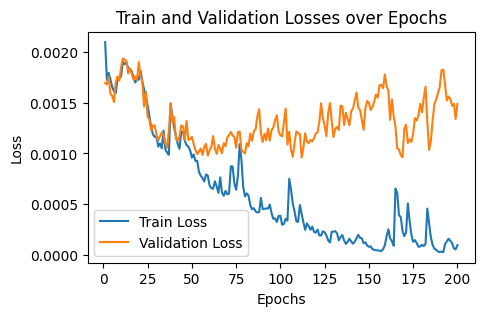

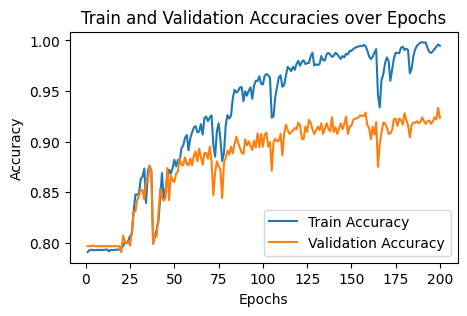

In [25]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH)
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH)

In [23]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/6000_LSTM_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

100%|██████████| 6/6 [00:00<00:00, 445.37it/s]

Best epoch: 199
macro F1 Score: 0.9043275165534531
AUROC: 0.9409136816148792
Accuracy: 0.9332892998678997


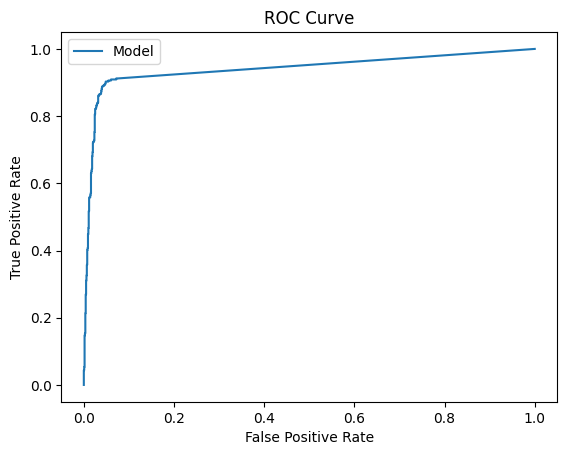

In [27]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)